### Pipeline Multi-Classification

L'objectif de ce notebook est d'expérimenter avec divers modèles pour résoudre une tâche de classification multiclasse. 
Plus précisément, nous cherchons à prédire à partir des données lors d'un demarragge d'un job, quel type de criticité est susceptible de survenenir à savoir; 
- Info
- Warning
- Error
- Aucun

Ce model sera le premier d'une paire de model ayant comme objectif de predire un type d'erreur précis. 
Si ce model predit une erreur, le deuxième model predira le type d'erreur que nous allons rencontré.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve

import mlflow
import mlflow.sklearn
from joblib import dump, load
import json




In [2]:
# nom de fichier et chemin relatif
filename = 'dataset_for_training_criticality_balanced_07.1.csv'
path = '../../data/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,duration,total_copies,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,...,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,mode_remoteScannerRegistration,criticality_events
0,171.889,1,700,520,740,2,False,1,1,0.059481,...,45,100,0,1500,1500,1500,16,16,1,INFO
1,152.296,1,700,520,740,2,False,1,1,0.060070,...,45,100,0,1817,1817,1817,19,20,1,NO_EVENT


In [3]:
df.shape

(18020, 28)

In [4]:
df.columns

Index(['duration', 'total_copies', 'speed', 'paperHeight_job',
       'paperWidth_job', 'total_copies_requested', 'ifoil', 'scanner_mode',
       'bars_job', 'varnishConsumptionVarnish_3d_job', 'LED', 'drops',
       'speed_ifoil', 'optifoil_ifoil', 'heater1Enabled_ifoil',
       'heater1Temperature_ifoil', 'x_imageLayout', 'y_imageLayout',
       'power_irDryers', 'power_uvDryers',
       'leftMargin_remoteScannerRegistration',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration',
       'mode_remoteScannerRegistration', 'criticality_events'],
      dtype='object')

In [5]:
df['criticality_events'].unique()

array(['INFO', 'NO_EVENT', 'WARNING', 'ERROR'], dtype=object)

In [6]:
df['criticality_events'].nunique()

4

In [7]:
df['criticality_events'].value_counts() 

INFO        4505
NO_EVENT    4505
WARNING     4505
ERROR       4505
Name: criticality_events, dtype: int64

In [8]:
df.head(5)

,duration,total_copies,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,...,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,mode_remoteScannerRegistration,criticality_events
0,171.889,1,700,520,740,2,False,1,1,0.059481,...,45,100,0,1500,1500,1500,16,16,1,INFO
1,152.296,1,700,520,740,2,False,1,1,0.060070,...,45,100,0,1817,1817,1817,19,20,1,NO_EVENT
2,44.259,2,700,520,740,2,False,1,1,0.251176,...,45,100,0,2484,2484,2484,24,27,1,INFO
3,44.259,2,700,520,740,2,False,1,1,0.251176,...,45,100,0,2484,2484,2484,24,27,1,NO_EVENT
4,68.216,2,359,520,740,2,False,1,1,0.251337,...,45,100,0,2484,2484,2484,24,27,1,INFO


In [9]:
df.dtypes

duration                                                float64
total_copies                                              int64
speed                                                     int64
paperHeight_job                                           int64
paperWidth_job                                            int64
total_copies_requested                                    int64
ifoil                                                      bool
scanner_mode                                              int64
bars_job                                                  int64
varnishConsumptionVarnish_3d_job                        float64
LED                                                       int64
drops                                                     int64
speed_ifoil                                             float64
optifoil_ifoil                                             bool
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                

In [10]:
# True pour utiliser StandardScaler, False pour utiliser MinMaxScaler
use_standard_scaler = True

if use_standard_scaler:
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()

# Sélectionnez uniquement les colonnes de type float64 pour la normalisation
float_columns = [col for col, col_type in df.dtypes.items() if col_type in ['float64','int64']]

df[float_columns] = scaler.fit_transform(df[float_columns])


In [11]:
df.head()

,duration,total_copies,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,...,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,mode_remoteScannerRegistration,criticality_events
0,-0.590817,-0.712321,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.628392,...,0.011576,0.466897,0.279644,-2.556137,-2.556137,-2.556137,-0.206084,-0.293147,-0.149122,INFO
1,-0.605795,-0.712321,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.628388,...,0.011576,0.466897,0.279644,-1.908889,-1.908889,-1.908889,0.183390,0.224340,-0.149122,NO_EVENT
2,-0.688384,-0.707831,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626926,...,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122,INFO
3,-0.688384,-0.707831,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626926,...,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122,NO_EVENT
4,-0.670070,-0.707831,-0.021680,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626925,...,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122,INFO


In [12]:
# Encodage de la colonne 'y' avec LabelEncoder
encoder = LabelEncoder()
df['criticality_events'] = encoder.fit_transform(df['criticality_events'])

In [13]:
# Sauvegarde de l'encoder et du scaler
dump(scaler, './mflow_object/scaler.joblib') 
dump(encoder, './mflow_object/encoder.joblib')

['./mflow_object/encoder.joblib']

In [14]:
# Séparation des données avec train_test_split
X = df.drop('criticality_events', axis=1)
y = df['criticality_events']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)



In [15]:
# fusionn des test set pour l'input json
example_input = pd.concat([X_test, y_test], axis=1)

# 1. Sélectionnez les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
last_rows_example = example_input.iloc[-5:]

# 2. Créez un objet JSON en utilisant les lignes et noms de colonnes originaux
example_input_json = last_rows_example.to_dict('records')

# Enregistrez l'objet JSON dans un fichier
with open("./mflow_object/input_exemple.json", "w") as f:
    json.dump(example_input_json, f)

In [16]:
y_train.value_counts()

1    3863
3    3843
0    3811
2    3800
Name: criticality_events, dtype: int64

### Data augmentation

Le code suivant est destiné à faire de la data augmentation sur un jeu de données en utilisant la méthode SMOTE (Synthetic Minority Over-sampling Technique).

Ce code commence par définir l'objet smote qui appliquera la méthode SMOTE à vos données. Il définit ensuite une variable **do_data_augmentation** qui, si elle est réglée sur **True**, indiquera au code d'effectuer une augmentation des données.

Si **do_data_augmentation** est **True**, le code fit et applique SMOTE à X_train et y_train, crée un nouvel ensemble de données augmentées et enregistre le schéma de ces nouvelles données dans input_schema et output_schema. Sinon, le schéma original est enregistré.

Le schéma est ensuite converti en un dictionnaire de types de données convertis en chaînes de caractères et est enregistré dans des fichiers *.json* : **input_schema.json** et **output_schema.json**. Ces fichiers sont utiles pour donner un exemple de ce que le modèle prend en entrée et en sortie.

Avantages de la méthode SMOTE :

Elle permet de surmonter le problème de déséquilibre de classe en augmentant artificiellement le nombre d'exemples dans les classes minoritaires.
Contrairement à d'autres techniques de suréchantillonnage (comme le suréchantillonnage aléatoire), SMOTE crée de nouvelles instances synthétiques plutôt que de simplement dupliquer les instances existantes, ce qui peut aider à prévenir le surapprentissage.

Inconvénients de la méthode SMOTE :

Elle peut générer des instances synthétiques qui sont bruyantes ou qui sont proches de la frontière de décision, ce qui peut rendre le modèle plus complexe et augmenter le risque de surapprentissage.
Elle ne fonctionne pas bien lorsque les classes minoritaires sont fortement déséquilibrées ou lorsque les classes minoritaires sont dispersées, car les instances synthétiques peuvent être créées à des endroits qui ne reflètent pas fidèlement la distribution sous-jacente des données.
Elle ne peut pas créer de nouvelles instances pour les classes qui n'ont qu'une seule instance, car il n'y a pas de voisins à partir desquels apprendre.

In [17]:
# Création d'une instance de l'objet SMOTE.
# SMOTE est une technique de suréchantillonnage qui fonctionne en créant des instances synthétiques des classes minoritaires.
# Ces instances sont créées en sélectionnant un nombre k (par défaut k=5) de voisins les plus proches dans l'espace des caractéristiques pour une instance donnée,
# et en créant une nouvelle instance qui se situe le long des lignes reliant cette instance à ses voisins.
# L'utilisation d'un random_state spécifique garantit que le suréchantillonnage sera toujours le même si vous exécutez à nouveau ce code.
smote = SMOTE(k_neighbors=1,random_state=42)

# Vérifier si vous voulez faire une augmentation des données si sur False les model s'entraineront sur les données initiales
do_data_augmentation = False


if do_data_augmentation:
    # Application de la méthode SMOTE à nos données.
    # Cela crée de nouvelles instances synthétiques des classes minoritaires, ce qui devrait aider à équilibrer les classes.
    # Le résultat est un nouvel ensemble de données X et un nouvel ensemble de labels y  qui contiennent les instances originales 
    # plus les nouvelles instances synthétiques.
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Sauvegarder le schéma d'entrée et de sortie pour le modèle
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = True
    print(y_train.value_counts())
else:
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = False
    print(y_train.value_counts())


# Convertir le schéma d'entrée et de sortie en JSON pour MLflow et les sauvegarder en artefact , 
# le schéma d'entré est trop long pour être sauvegardé avec le format initial 
# (500 caractère max mais plus de 900 dans notre cas) : # mlflow.log_param("input_schema", input_schema)
input_schema = X_train.dtypes.astype(str).to_dict()
output_schema = {"output": str(y_train.dtype)}

y_value_count = y_train.value_counts()

with open("./mflow_object/input_schema.json", "w") as f:
    json.dump(input_schema, f)

# Convertir le schéma de sortie en JSON
with open("./mflow_object/output_schema.json", "w") as f:
    json.dump(output_schema, f)
input_schema

1    3863
3    3843
0    3811
2    3800
Name: criticality_events, dtype: int64


{'duration': 'float64',
 'total_copies': 'float64',
 'speed': 'float64',
 'paperHeight_job': 'float64',
 'paperWidth_job': 'float64',
 'total_copies_requested': 'float64',
 'ifoil': 'bool',
 'scanner_mode': 'float64',
 'bars_job': 'float64',
 'varnishConsumptionVarnish_3d_job': 'float64',
 'LED': 'float64',
 'drops': 'float64',
 'speed_ifoil': 'float64',
 'optifoil_ifoil': 'bool',
 'heater1Enabled_ifoil': 'bool',
 'heater1Temperature_ifoil': 'float64',
 'x_imageLayout': 'float64',
 'y_imageLayout': 'float64',
 'power_irDryers': 'float64',
 'power_uvDryers': 'float64',
 'leftMargin_remoteScannerRegistration': 'float64',
 'redScore_gridMode_remoteScannerRegistration': 'float64',
 'redScore_cropmarksMode_remoteScannerRegistration': 'float64',
 'redScore_fullScannerMode_remoteScannerRegistration': 'float64',
 'blueScore_fullScannerMode_remoteScannerRegistration': 'float64',
 'greenScore_fullScannerMode_remoteScannerRegistration': 'float64',
 'mode_remoteScannerRegistration': 'float64'}

In [18]:
X

,duration,total_copies,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,...,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,mode_remoteScannerRegistration
0,-0.590817,-0.712321,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.628392,...,0.265269,0.011576,0.466897,0.279644,-2.556137,-2.556137,-2.556137,-0.206084,-0.293147,-0.149122
1,-0.605795,-0.712321,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.628388,...,0.265269,0.011576,0.466897,0.279644,-1.908889,-1.908889,-1.908889,0.183390,0.224340,-0.149122
2,-0.688384,-0.707831,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626926,...,0.265269,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122
3,-0.688384,-0.707831,2.820714,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626926,...,0.265269,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122
4,-0.670070,-0.707831,-0.021680,-0.262884,0.758233,-0.770134,False,-0.149122,-2.377889,-0.626925,...,0.265269,0.011576,0.466897,0.279644,-0.547012,-0.547012,-0.547012,0.832512,1.129941,-0.149122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18015,-0.556931,-0.635992,-1.547070,-0.702097,-1.498670,-0.572595,False,-0.149122,0.420541,-0.459896,...,0.265269,0.011576,0.466897,0.279644,0.782196,0.782196,0.782196,-0.985031,-0.940005,-0.149122
18016,-0.667133,-0.698851,-1.547070,-0.702097,-1.498670,-0.572595,False,-0.149122,0.420541,-0.596386,...,0.265269,0.011576,0.466897,0.279644,0.782196,0.782196,0.782196,-0.985031,-0.940005,-0.149122
18017,-0.712110,-0.716811,-1.547070,-0.702097,-1.498670,-0.767601,False,-0.149122,0.420541,-0.628847,...,0.265269,0.011576,0.466897,0.279644,0.782196,0.782196,0.782196,-0.985031,-0.940005,-0.149122
18018,-0.628676,-0.703341,-1.547070,-0.702097,-1.498670,-0.767601,False,-0.149122,0.420541,-0.600618,...,0.265269,0.011576,0.466897,0.279644,0.782196,0.782196,0.782196,-0.985031,-0.940005,-0.149122


In [19]:
X_train.dtypes

duration                                                float64
total_copies                                            float64
speed                                                   float64
paperHeight_job                                         float64
paperWidth_job                                          float64
total_copies_requested                                  float64
ifoil                                                      bool
scanner_mode                                            float64
bars_job                                                float64
varnishConsumptionVarnish_3d_job                        float64
LED                                                     float64
drops                                                   float64
speed_ifoil                                             float64
optifoil_ifoil                                             bool
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                

### Pipeline
Ce code est divisé en trois cellules

In [20]:
# Déclaration des modèles et leurs hyperparamètres
models = {
    "lr": {
        "model": LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        "params": {"model__C": [0.1, 1.0, 10.0]}
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100, 200],
            "model__max_depth": [None, 10, 20,50],
            "model__min_samples_split": [2, 5, 10,25],
            "model__min_samples_leaf": [1, 2, 4,10]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {"model__C": [0.1, 1.0, 10.0], "model__gamma": [0.1, 1.0, 10.0]}
    }
}

# Liste des modèles à inclure
include_models = ["lr", "rf"]

pipelines = {key: Pipeline([("scaler", scaler), ("model", models[key]["model"])]) for key in include_models}
param_grids = {key: models[key]["params"] for key in include_models}

In [21]:
# Dictionnaire pour renommer les abréviations de modèles par leurs noms complets pour mlflow
model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest",
    "svc": "Support Vector Classifier"
}

# Création d'un dictionnaire pour chaque modèle indiquant les hyperparamètres utilisés
model_hyperparams = {model_names[key]: list(param_grids[key].keys()) for key in include_models}

# Afficher les hyperparamètres de chaque modèle
print(model_hyperparams)

# Enregistrement des hyperparamètres de chaque modèle au format JSON
with open("./mflow_object/model_hyperparams.json", "w") as f:
    json.dump(model_hyperparams, f)

{'Logistic Regression': ['model__C'], 'Random Forest': ['model__n_estimators', 'model__max_depth', 'model__min_samples_split', 'model__min_samples_leaf']}


In [22]:
# Initialisation de la liste pour stocker les résultats
results = []

# Initialisation du meilleur modèle et du meilleur score
best_model = None
best_score = 0

Voici une description détaillée de chaque partie du code :

**Démarrer une expérience MLflow** : La ligne mlflow.start_run() démarre une nouvelle expérience MLflow, ce qui permet de tracker les différentes métriques, paramètres et artefacts pour chaque modèle.

**Boucle de modélisation et de recherche en grille** : Cette boucle itère sur chaque modèle défini précédemment dans le pipeline. Pour chaque modèle, une recherche en grille (Grid Search) est effectuée sur l'ensemble des paramètres définis pour ce modèle, en utilisant une validation croisée stratifiée de 5-fold (cv=5).

**Entraînement et prédiction** : Le modèle est entraîné sur l'ensemble d'entraînement (X_train et y_train) et ensuite utilisé pour prédire les labels de l'ensemble de test (X_test).

**Évaluation du modèle** : Le modèle est évalué en calculant l'accuracy et le recall sur l'ensemble de test.

**Sélection du meilleur modèle** : Si l'accuracy du modèle actuel est supérieure à celle du meilleur modèle précédemment trouvé, le modèle actuel devient le nouveau meilleur modèle.

**Stockage des résultats** : Les résultats de chaque modèle sont stockés dans une liste sous forme de dictionnaires.

**Courbe d'apprentissage** : Les courbes d'apprentissage sont générées pour chaque modèle en utilisant la fonction learning_curve. Cette fonction génère un graphique montrant l'évolution de l'accuracy en fonction de la taille de l'échantillon d'entraînement. Elle est utilisée pour vérifier si le modèle souffre de sous-apprentissage ou de sur-apprentissage.

**Enregistrement des modèles et des artefacts avec MLflow** : Les informations sur les modèles, comme l'accuracy, le recall, les courbes d'apprentissage, les schémas d'entrée et de sortie, les hyperparamètres utilisés, etc., sont enregistrées avec MLflow pour un suivi facile.

**Sauvegarde du meilleur modèle** : Le meilleur modèle (avec la meilleure accuracy) est enregistré pour une utilisation future.

**Conversion des résultats en DataFrame** : Les résultats sont convertis en un DataFrame pour faciliter la visualisation et l'analyse.

Fitting 5 folds for each of 3 candidates, totalling 15 fits


p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


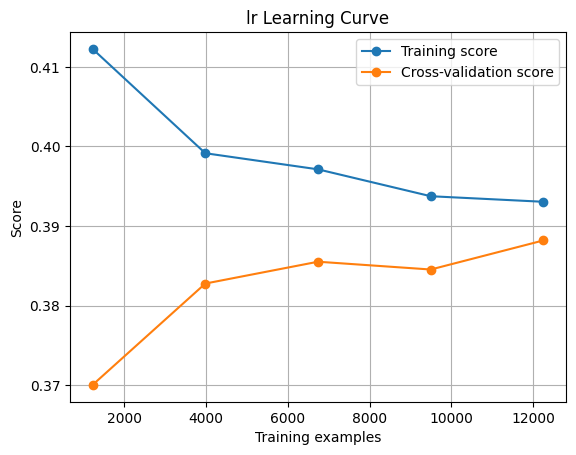

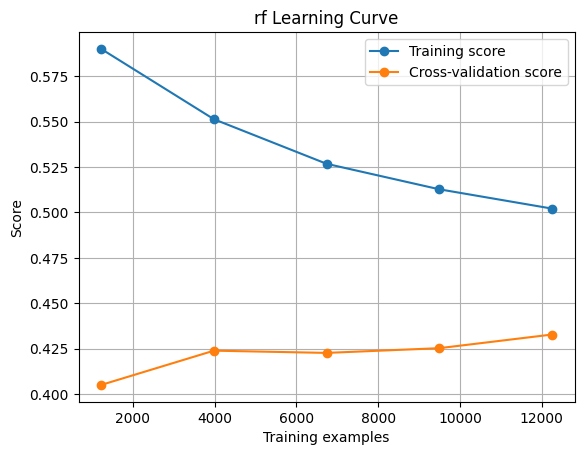

In [23]:
mlflow.start_run()

# Boucle sur les pipelines et effectue une recherche sur grille pour chaque modèle
for model_name, pipeline in pipelines.items():
    # Création d'une instance de GridSearchCV avec le pipeline et les paramètres correspondants
    model = GridSearchCV(pipeline, param_grids[model_name], cv=5, verbose=2, n_jobs=-1)
    # Entraînement du modèle GridSearchCV sur l'ensemble d'entraînement
    model.fit(X_train, y_train)
        
    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)
        
    # Calcul de l'accuracy et du recall sur l'ensemble de test
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro') # "macro" pour le recall non pondéré
        
    # Mise à jour du meilleur modèle si l'accuracy de l'actuel est meilleure
    if accuracy > best_score:
        best_model = model
        best_score = accuracy
        best_model_name = model_name

    # Stockage des résultats dans une liste
    results.append({"model": model_name, "accuracy": accuracy, "recall": recall})
        
    # Enregistrement de l'accuracy et du recall avec mlflow
    mlflow.log_metric(f"{model_name}_accuracy", accuracy)
    mlflow.log_metric(f"{model_name}_recall", recall)

    # Génération de la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model.best_estimator_, X_train, y_train, cv=5, scoring='accuracy', 
        train_sizes=np.linspace(.1, 1.0, 5))
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()

    # Sauvegarde de la figure de la courbe d'apprentissage
    plt.savefig(f"./mflow_object/{model_name}_learning_curve.png")
    
    # Enregistrement de la figure de la courbe d'apprentissage avec mlflow
    mlflow.log_artifact(f"./mflow_object/{model_name}_learning_curve.png")

# Sauvegarde du meilleur modèle
mlflow.sklearn.log_model(best_model.best_estimator_, f"best_model_{best_model_name}")

# Enregistrer les schémas comme artefacts MLflow
mlflow.log_artifact("./mflow_object/input_schema.json")
mlflow.log_artifact("./mflow_object/output_schema.json")

# Enregistrement d'un exemple pour l'API 
mlflow.log_artifact("./mflow_object/input_exemple.json")

# Enregistrement des modèles avec leurs hyperparamètres qui ont été utilisés dans le pipeline
mlflow.log_param("model_hyperparams", model_hyperparams)

   
# Sauvegarder si une augmentation de données a été attribuée
mlflow.log_param("data_augmentation", data_augmentation_done)

# Sauvegarde des encoder et scaler pour le run
mlflow.log_artifact('./mflow_object/scaler.joblib')
mlflow.log_artifact('./mflow_object/encoder.joblib')

# Conversion des résultats en DataFrame pour faciliter le traçage
results_df = pd.DataFrame(results)

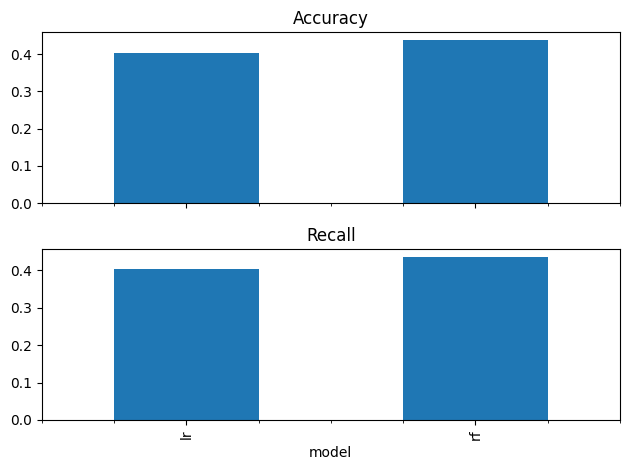

Le meilleur modèle de prediction de criticité du run est Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=25,
                                        n_estimators=25))]) avec une précision de 0.437


"Le meilleur modèle de prediction de criticité du run est Pipeline(steps=[('scaler', StandardScaler()),\n                ('model',\n                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,\n                                        min_samples_split=25,\n                                        n_estimators=25))]) avec une précision de 0.437"

In [26]:
# Tracé des résultats
fig, ax = plt.subplots(2, 1, sharex=True)
results_df.plot(kind='bar', x='model', y='accuracy', ax=ax[0], legend=False, title='Accuracy')
results_df.plot(kind='bar', x='model', y='recall', ax=ax[1], legend=False, title='Recall')

plt.tight_layout()

# Enregistrement du plot dans un fichier
plt.savefig("./mflow_object/accuracy_recall_plot.png")

# Affichage du plot
plt.show()

# Enregistrement du fichier dans MLflow
mlflow.log_artifact("./mflow_object/accuracy_recall_plot.png")

# run_id = mlflow.get_run()
# Affichage du meilleur modèle
best_model_info = f"Le meilleur modèle de prediction de criticité du run est {best_model.best_estimator_} avec une précision de {best_score:.3f}"
print(best_model_info)

# Enregistrement de l'information du meilleur modèle dans MLflow
mlflow.log_param("best_model_info", best_model_info)

In [25]:
# Calcul du recall général
recall_general = recall_score(y_test, y_pred, average='macro')

print('Recall général: ', recall_general)

# Génération de la matrice de confusion
cm = confusion_matrix(y_test, best_model.predict(X_test))

# Décodage des classes
classes = encoder.inverse_transform([i for i in range(len(cm))])

# Création du DataFrame
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Enregistrement du DataFrame en format CSV
cm_df.to_csv("./mflow_object/confusion_matrix.csv")

# Enregistrement du fichier CSV dans MLflow
mlflow.log_artifact("./mflow_object/confusion_matrix.csv")

# Génération du rapport de classification
report = classification_report(y_test, best_model.predict(X_test), target_names=classes)

# Enregistrement du rapport dans un fichier texte
with open("./mflow_object/classification_report.txt", "w") as f:
    f.write(report)

# Enregistrement du fichier texte dans MLflow
mlflow.log_artifact("./mflow_object/classification_report.txt")

print(report)

# End MLflow tracking
mlflow.end_run()

Recall général:  0.4344186552159376
              precision    recall  f1-score   support

       ERROR       0.48      0.43      0.45       694
        INFO       0.49      0.47      0.48       642
    NO_EVENT       0.45      0.59      0.51       705
     WARNING       0.31      0.25      0.28       662

    accuracy                           0.44      2703
   macro avg       0.43      0.43      0.43      2703
weighted avg       0.43      0.44      0.43      2703

